<a href="https://colab.research.google.com/github/naydennenkov/ML_examples/blob/master/kaggle_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Соревнования по распознаванию рукописных цифр на Kaggle

Пример кода для отправки решения в соревнование Kaggle - https://www.kaggle.com/c/digit-recognizer

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://www.asozykin.ru/courses/nnpython)".

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (File->Save a copy in Drive...). Свою копию вы сможете изменять и запускать.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten 
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Настраиваем Kaggle API

Загружаем токен аутентификации

In [13]:
file = files.upload()

Saving kaggle.json to kaggle.json


In [14]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv.zip  train.csv.zip


Копируем токен в каталог .kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

## Загружаем данные с сайта Kaggle

In [16]:
!kaggle competitions download -c digit-recognizer

test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv.zip  train.csv.zip


## Проверяем формат данных

Данные для обучения

In [18]:
!head train.csv

head: cannot open 'train.csv' for reading: No such file or directory


Данные для тестирования

In [ ]:
!head test.csv

pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pix

Пример файла с решением

In [22]:
!head sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Подготовка данных для обучения сети

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [31]:
!ls "/content/drive/My Drive/Colab Notebooks"

'Copy of kaggle_mnist.ipynb'   Untitled0.ipynb	 Untitled3.ipynb
 digit-recognizer	       Untitled1.ipynb
 MyFirstNoteBookColab.ipynb    Untitled2.ipynb


In [33]:
from google.colab import files
files.upload()
files.download('/content/My Drive/My Drive/Colab Notebooks/digit-recognizer/train.csv')

Saving train.csv to train (2).csv


FileNotFoundError: ignored

Загружаем данные для обучения из файла

In [20]:
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

OSError: ignored

In [23]:
train_dataset[0:5]

NameError: ignored

Выделяем данные для обучения

In [ ]:
x_train = train_dataset[:, 1:]
# Переформатируем данные в 2D, бэкенд TensorFlow
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

Нормализуем данные для обучения

In [ ]:
x_train /= 255.0

In [ ]:
x_train[1].shape

Выделяем правильные ответы

In [ ]:
y_train = train_dataset[:, 0]

In [ ]:
y_train[:5]

Преобразуем ответы в формат one hot encoding

In [ ]:
y_train = utils.to_categorical(y_train)

In [ ]:
y_train[:5]

Разделяем набор данных на две части: для обучения (X_Train, Y_train) и проверки (X_val, Y_val)

In [ ]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
X_train.shape

Создаем генератор для расширения данных

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [ ]:
i = 0
data = X_train[0]
data = np.expand_dims(data, axis=0)
for batch in datagen.flow(data, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0][:,:,0])
    i += 1
    if i % 6 == 0:
        break
plt.show()

## Создаем нейронную сеть

**Создаем последовательную модель**

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Компилируем сеть**

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
__________

## Обучаем нейронную сеть

In [ ]:
сheckpoint = ModelCheckpoint('mnist-cnn.h5', 
                              monitor='val_acc', 
                              save_best_only=True,
                              verbose=1)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
batch_size=96

In [ ]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), 
                    epochs=30,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[сheckpoint, learning_rate_reduction])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
4200/4200 [==============================] - 1s 155us/sample - loss: 0.0646 - acc: 0.9795

Epoch 00001: val_acc improved from -inf to 0.97952, saving model to mnist-cnn.hdf5
394/394 [==============================] - 18s 47ms/step - loss: 0.4372 - acc: 0.8576 - val_loss: 0.0646 - val_acc: 0.9795
Epoch 2/30
4200/4200 [==============================] - 1s 130us/sample - loss: 0.0418 - acc: 0.9867

Epoch 00002: val_acc improved from 0.97952 to 0.98667, saving model to mnist-cnn.hdf5
394/394 [==============================] - 17s 43ms/step - loss: 0.1366 - acc: 0.9583 - val_loss: 0.0417 - val_acc: 0.9867
Epoch 3/30
4200/4200 [==============================] - 1s 119us/sample - loss: 0.0349 - acc: 0.9907

Epoch 00003: val_acc improved from 0.98667 to 0.99071, saving model to mnist-cnn.hdf5
394/394 [==============================] - 17s 42ms/step - loss: 0.0987 - acc: 0.9702 - val_loss: 0.0349 - val_acc: 0.9907
Epoch 4/30
4200/4200 [

In [ ]:
model.load_weights('mnist-cnn.hdf5')

## Визуализация качества обучения


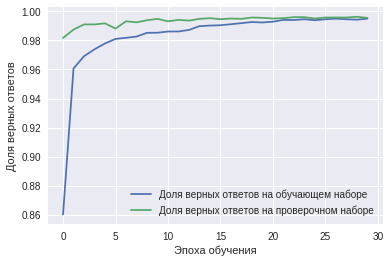

In [ ]:
plt.plot(history.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Загружаем данные для распознавания

In [ ]:
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")

In [ ]:
test_dataset[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

Нормализация данных

In [ ]:
x_test = x_test / 255.0

## Запускаем распознавание рукописных цифр из тестового набора данных

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions[:5]

array([[7.0808330e-19, 1.2293642e-15, 1.0000000e+00, 1.6526332e-13,
        4.8959526e-16, 1.6048716e-18, 1.2838233e-17, 1.1961627e-12,
        7.7564989e-14, 2.3213994e-16],
       [9.9999893e-01, 1.6688695e-12, 6.3178089e-09, 6.3089062e-10,
        7.1604861e-10, 2.8566465e-09, 2.1731910e-07, 2.6650182e-10,
        3.7282078e-07, 4.8097058e-07],
       [2.9786121e-10, 2.6178534e-10, 1.4524261e-07, 1.2859771e-09,
        5.9936187e-06, 1.6657364e-10, 6.1487855e-12, 1.1224843e-08,
        2.0155933e-06, 9.9999177e-01],
       [9.9914634e-01, 1.0904064e-07, 7.0121109e-06, 1.3721834e-05,
        4.1037286e-08, 5.3695007e-06, 3.6620080e-05, 4.0169263e-07,
        2.4500233e-04, 5.4535794e-04],
       [2.5390169e-13, 2.4379212e-11, 6.3516737e-08, 9.9996173e-01,
        3.9227069e-17, 2.6025369e-09, 1.9312415e-11, 3.6186339e-11,
        3.8091617e-05, 5.9398592e-10]], dtype=float32)

Преобразуем результаты распознавания из формата one hot encoding в цифры

In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
predictions[:5]

array([2, 0, 9, 0, 3])

## Готовим файл с решением для Kaggle

In [ ]:
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [ ]:
out[:5]

array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

Записываем результаты в файл 

In [ ]:
np.savetxt('submission.csv', out, header="ImageId,Label", 
            comments="", fmt="%d,%d")

In [ ]:
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


## Отправляем решение на соревнование

In [ ]:
!kaggle competitions submit -c digit-recognizer -m "Submition from Colab" -f submission.csv

100% 208k/208k [00:04<00:00, 43.7kB/s]
Successfully submitted to Digit Recognizer